<a href="https://colab.research.google.com/github/ZachFunk/3D-GAP-Masters-Thesis/blob/main/InternalStatistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PIP

In [ ]:
!pip install tifffile
!pip install imagecodecs
!pip install optuna
from google.colab import drive
drive.mount('/content/drive')

# Import

In [ ]:
import tifffile as tiff
from tifffile import imwrite, imshow, imread
import matplotlib.pyplot as plt
import numpy as np
import imagecodecs
import torch
import optuna
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

still_data = tiff.imread('/content/drive/MyDrive/MastersThesis/data/clean_30Hz_256x256x(0-1000).tif')


# Filters

In [ ]:
import torch
import numpy as np
from scipy.ndimage import gaussian_filter


def apply_filters(stacked_imgs,  median_neighbours = 1, geo_neighbours = 4, okada_neighbours = 1, geo_alpha = 0.7, okada_alpha = 0.5, median_alpha = 0.2, sigma = 1.0, device = 'cpu'):

    """
    Applies various filters to a stack of images and normalizes the results.

    Parameters:norm
    - stacked_imgs (torch.Tensor): The input image stack tensor. Shape (N, C, H, W). Assumed to normalized and scalled to [0,255]
    - num_neighbours (int): Number of neighbors for filtering functions that require it.
    - Hyper Parameter for Median, Geometric, and Okada Filter
    - device (torch.device): The device to which tensors are moved (e.g., 'cpu' or 'cuda').

    Returns:
    - normalized_geometric_imgs (torch.Tensor): Normalized geometric filtered images.
    - normalized_median_imgs (torch.Tensor): Normalized median filtered images.
    - normalized_okada_imgs (torch.Tensor): Normalized Okada filtered images.
    - normalized_gaussian_imgs (torch.Tensor): Normalized Gaussian filtered images. Dtype = float

    """
    # move stacked_imgs to device
    stacked_imgs = stacked_imgs.to(device)


    # Apply filters
    geometric_imgs = geometric_filtering(stacked_imgs.clone(), geo_neighbours, geo_alpha)
    median_imgs    = median_filtering   (stacked_imgs.clone(), median_neighbours, median_alpha)
    okada_imgs     = okada_filtering    (stacked_imgs.clone(), okada_neighbours, okada_alpha)
    gaussian_imgs  = gaussian_filtering (stacked_imgs.clone(), sigma)

    # Move tensors to CPU
    geometric_imgs = [img.cpu() for img in geometric_imgs]
    median_imgs = [img.cpu() for img in median_imgs]
    okada_imgs = [img.cpu() for img in okada_imgs]
    gaussian_imgs = [img.cpu() for img in gaussian_imgs]
    stacked_imgs = stacked_imgs.cpu()

    # Convert lists to tensors and normalize
    def normalize_images(images):
        img_tensor = torch.stack([img.to(torch.float32) for img in images])
        return (img_tensor - torch.min(img_tensor)) / (torch.max(img_tensor) - torch.min(img_tensor)) * 255.0

    normalized_geometric_imgs = normalize_images(geometric_imgs)
    normalized_median_imgs = normalize_images(median_imgs)
    normalized_okada_imgs = normalize_images(okada_imgs)
    normalized_gaussian_imgs = normalize_images(gaussian_imgs)
    normalized_stacked_imgs = normalize_images(stacked_imgs)


    return normalized_geometric_imgs, normalized_median_imgs, normalized_okada_imgs, normalized_gaussian_imgs, normalized_stacked_imgs


def okada_filtering(stacked_imgs, neighbours, alpha, device = 'cpu'):
  '''
  input: tensor of stacked images
  output: tensor of filtered images
  '''


  for idx in range(len(stacked_imgs)):
    # Initialize the target_img and previous_imgs and following_imgs
    target_img = stacked_imgs[idx]


    # previous images
    if idx == 0:
      previous_imgs = torch.zeros_like(target_img).unsqueeze(0)  # Single zero tensor for insufficient previous
    elif idx < neighbours:
     previous_imgs = stacked_imgs[:idx]  # Take what we can
    else:
        previous_imgs = stacked_imgs[idx-neighbours:idx]

    # following images
    if idx == len(stacked_imgs) - 1:  # Check if it's the last image
        following_imgs = torch.zeros_like(target_img).unsqueeze(0)  # Single zero tensor for insufficient following
    elif idx + neighbours >= len(stacked_imgs):  # Check if there are enough following images
        following_imgs = stacked_imgs[idx + 1:]  # Take what we can
    else:
        following_imgs = stacked_imgs[idx + 1: idx + 1 + neighbours]


    all_vals = torch.cat((previous_imgs, target_img.unsqueeze(0), following_imgs),dim=0)

    # Calculate the median of the values

    previous_average =  torch.mean(previous_imgs,dim=0)
    following_average = torch.mean(following_imgs, dim = 0)

    factor = 2 * (1 + torch.exp(-alpha * (target_img - previous_average ) * (target_img - following_average)))

    addition = (previous_average + following_average - 2 * target_img) / factor
    filtered_img = target_img + addition

    filtered_img = torch.clamp(filtered_img, min=0, max=torch.finfo(torch.float32).max).to(torch.int)
    stacked_imgs[idx] = filtered_img

  return stacked_imgs



# IDEA: Combine the median and the geometric filter to create a new one. We take the median of the 3 frames and then weight the frames based on their distance from the median.
# Frames with a larger distance from the median have more/less influence (weight) on the geometric addition.


def median_filtering(stacked_imgs, neighbours, alpha):
    '''
    input: tensor of stacked images
    output: tensor of filtered images
    '''

    for idx in range(len(stacked_imgs)):
        # Initialize the target_img and previous_imgs and following_imgs
        target_img = stacked_imgs[idx]

        # previous images
        if idx == 0:
            previous_imgs = torch.zeros_like(target_img).unsqueeze(0)  # Single zero tensor for insufficient previous
        elif idx < neighbours:
            previous_imgs = stacked_imgs[:idx]  # Take what we can
        else:
            previous_imgs = stacked_imgs[idx-neighbours:idx]

        # following images
        if idx == len(stacked_imgs) - 1:  # Check if it's the last image
            following_imgs = torch.zeros_like(target_img).unsqueeze(0)  # Single zero tensor for insufficient following
        elif idx + neighbours >= len(stacked_imgs):
            following_imgs = stacked_imgs[idx + 1:]  # Take what we can
        else:
            following_imgs = stacked_imgs[idx + 1: idx + 1 + neighbours]

        all_vals = torch.cat((previous_imgs, target_img.unsqueeze(0), following_imgs), dim=0)

        # Calculate the median of the values
        median = torch.median(all_vals, dim=0).values
        previous_average = torch.mean(previous_imgs, dim=0)
        following_average = torch.mean(following_imgs, dim=0)

        factor = 2 * (1 + torch.exp(-alpha * (median - previous_average) * (median - following_average)))
        addition = (previous_average + following_average - 2 * median) / factor
        filtered_img = median + addition

        filtered_img = torch.clamp(filtered_img, min=0, max=torch.finfo(torch.float32).max).to(torch.int)
        stacked_imgs[idx] = filtered_img

    return stacked_imgs



def gaussian_filtering(stacked_imgs, sigma=1.0):
    """
    Apply a Gaussian filter to a stack of images.

    Parameters:
        stacked_imgs (torch.Tensor): A tensor of stacked images.
        sigma (float): Standard deviation for Gaussian kernel.
        device (str): Device to which tensor should be moved ('cpu' or 'cuda').

    Returns:
        filtered_imgs (torch.Tensor): Tensor of filtered images.
        gaussian_imgs (list): List of filtered images.
    """


    # Make the stack images floating point
    stacked_imgs = stacked_imgs.float()

    # Convert the stack to a NumPy array
    stacked_imgs_np = stacked_imgs.cpu().numpy()  # Move to CPU and convert to NumPy

    # Apply Gaussian filter to each image in the stack
    filtered_imgs_np = np.array([gaussian_filter(img, sigma=sigma) for img in stacked_imgs_np])

    # Convert the filtered images back to PyTorch tensors
    filtered_imgs = torch.from_numpy(filtered_imgs_np)



    return filtered_imgs



import torch
def geometric_filtering(stacked_data, neighbours, alpha):
  '''
  input: tensor of stacked images
  output: tensor of filtered images
  '''

  # Calculate weights. Images closer to the target contribute more.
  weights = torch.zeros(neighbours * 2 + 1)
  total_images = neighbours * 2 + 1
  for i in range(total_images):
      distance = min(i, total_images - 1 - i)  # Distance from the center
      weights[i] = total_images - distance   # Weights increase as distance decreases

  # Normalize the weights
  weights = 1.0 / weights  # Inverse of distance
  weights /= weights.sum()  # Normalize

  filtered_images = []
  for idx in range(len(stacked_data)):
    # Initialize the target_img and previous_imgs and following_imgs
    target_img = stacked_data[idx]


    # previous images
    if idx == 0:
      previous_imgs = torch.zeros_like(target_img).unsqueeze(0)  # Single zero tensor for insufficient previous
    elif idx < neighbours:
     previous_imgs = stacked_data[:idx]  # Take what we can
    else:
        previous_imgs = stacked_data[idx-neighbours:idx]

    # following images
    if idx == len(stacked_data) - 1:  # Check if it's the last image
        following_imgs = torch.zeros_like(target_img).unsqueeze(0)  # Single zero tensor for insufficient following
    elif idx + neighbours >= len(stacked_data):  # Check if there are enough following images
        following_imgs = stacked_data[idx + 1:]  # Take what we can
    else:
        following_imgs = stacked_data[idx + 1: idx + 1 + neighbours]


     # Calculate weights for previous images
    weighted_previous = torch.zeros_like(previous_imgs)
    for i in range(previous_imgs.shape[0]):
        weighted_previous[i] = previous_imgs[i] * weights[len(previous_imgs) - i]  # Assign closer weights


    # Calculate weights for following images
    weighted_following = torch.zeros_like(following_imgs)
    for i in range(following_imgs.shape[0]):
        weighted_following[i] = following_imgs[i] * weights[i + len(previous_imgs) + 1]  # Assign closer weights


    # Calculate weight for the target image
    weighted_target = target_img * weights[len(previous_imgs)]  # Center weight
    weighted_target.unsqueeze(0)


    weighted_previous_sum = weighted_previous.sum(dim=0)
    weighted_following_sum = weighted_following.sum(dim=0)

    factor = 2 * (1 + torch.exp(-alpha * (weighted_target - weighted_previous_sum ) * (weighted_target - weighted_following_sum)))

    addition = (weighted_previous_sum + weighted_following_sum - 2 * weighted_target) / factor



    filtered_img = weighted_target + addition
    filtered_img = torch.clamp(filtered_img, min=0, max=torch.finfo(torch.float32).max).to(torch.int)

    stacked_data[idx] = filtered_img


  return stacked_data




# Create Data

In [ ]:
def add_poisson_noise(data, noise_scale=150):
    """
    Preprocesses image data by normalizing, adding Poisson noise, and scaling.

    Parameters:
    - data (numpy.ndarray): The input image data in numpy array format.
    - noise_scale (float): The scaling factor for Poisson noise.

    Returns:
    - gt_data_vis (torch.Tensor): Normalized and scaled ground truth data.
    - noisy_data (torch.Tensor): Normalized, scaled, and noise-added data.
    """

    gt_data = torch.from_numpy(data).float()
    gt_data = (gt_data - gt_data.min()) / (gt_data.max() - gt_data.min())
    gt_data = gt_data*255


    noisy_data = torch.poisson(gt_data * noise_scale)
    noisy_data = (noisy_data - noisy_data.min()) / (noisy_data.max() - noisy_data.min())
    noisy_data = noisy_data * 255

    return gt_data, noisy_data

In [ ]:
gt_data, noisy_data = add_poisson_noise(still_data[:5], 0.2)

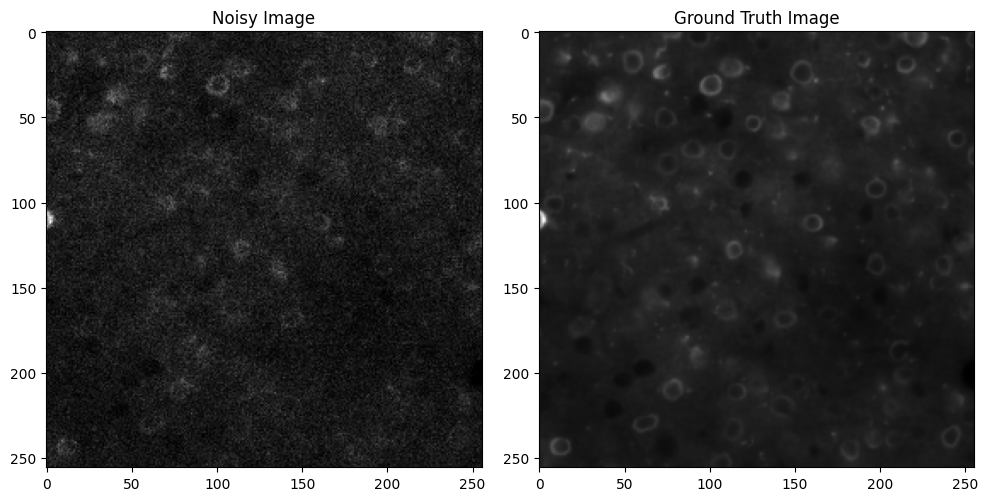

In [ ]:
# prompt: plt noisy img and gt_img side by side in a tight layout. label and keep axid on

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(noisy_data[0], cmap='gray')
ax[0].set_title('Noisy Image')
ax[0].axis('on')

ax[1].imshow(gt_data[0], cmap='gray')
ax[1].set_title('Ground Truth Image')
ax[1].axis('on')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_image_with_snr(image, denoised_snr, filename='filtered_image.png', title='Filtered Image'):
    """
    Plot an image with SNR annotations and save it as a PNG file.

    Parameters:
    - image: The image to plot.
    - noisy_snr: The SNR of the noisy image compared to the filtered image.
    - denoised_snr: The SNR of the filtered image compared to the ground truth.
    - filename: The name of the file to save the plot as.
    - title: The title of the plot.
    """
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

    # Annotation text
    text = f'SNR: {denoised_snr:.2f}'

    # Create a patch to place the text
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.7)
    ax.text(0.95, 0.05, text, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', horizontalalignment='right', bbox=bbox_props)

    # Save the plot as a PNG file
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close(fig)


def plot_image(image,  filename='filtered_image.png', title='Filtered Image'):
    """
    Plot an image with SNR annotations and save it as a PNG file.

    Parameters:
    - image: The image to plot.
    - noisy_snr: The SNR of the noisy image compared to the filtered image.
    - denoised_snr: The SNR of the filtered image compared to the ground truth.
    - filename: The name of the file to save the plot as.
    - title: The title of the plot.
    """
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')



    # Save the plot as a PNG file
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close(fig)

In [ ]:
def calculate_snr(gt_data, noisy_data):
    """
    Calculate the overall SNR for a dataset of images with channel dimension.

    Parameters:
    - gt_data (torch.Tensor): The ground truth image tensor. Should be of shape (N, C, H, W).
    - noisy_data (torch.Tensor): The noisy image tensor. Should be of shape (N, C, H, W).

    Returns:
    - overall_snr_db (float): The overall SNR for the dataset in dB.
    """

    # Calculate signal power for all images at once
    signal_power = torch.mean(gt_data ** 2, dim=(1))

    # Calculate noise for all images at once
    noise = noisy_data - gt_data

    # Calculate noise power for all images at once
    noise_power = torch.mean(noise ** 2, dim=(1))

    # Calculate overall SNR for all images
    overall_snr = torch.mean(signal_power / noise_power)

    # Convert to dB
    overall_snr_db = 10 * torch.log10(overall_snr)

    return overall_snr_db.item()

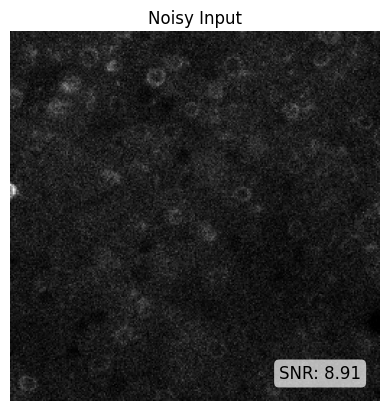

In [ ]:
path = '/content/drive/MyDrive/MastersThesis/Analysis/data/NAOMi/Noisy_Input.png'
title = 'Noisy Input'
denoised_snr = calculate_snr(gt_data[3], noisy_data[3])
plot_image_with_snr(noisy_data[3], denoised_snr, path, title)

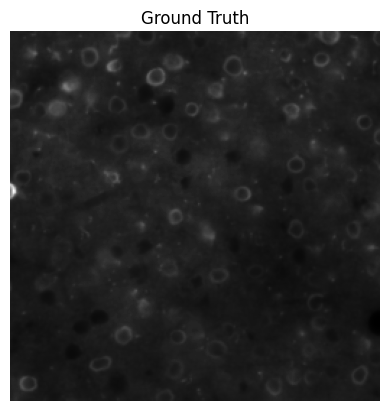

In [ ]:
path = '/content/drive/MyDrive/MastersThesis/Analysis/data/NAOMi/Ground_Truth.png'
title = 'Ground Truth'
plot_image(gt_data[3], path, title)

# Okada Filter


In [ ]:
def plot_image_with_snr_okada(image, denoised_snr, weights, filename='filtered_image.png', title='Filtered Image'):
    """
    Plot an image with SNR annotations and save it as a PNG file.

    Parameters:
    - image: The image to plot.
    - denoised_snr: The SNR of the filtered image compared to the ground truth.
    - weights: The list of weights used in the filtering process.
    - filename: The name of the file to save the plot as.
    - title: The title of the plot.
    """
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

    neighbours=weights[0]
    alpha=weights[1]  # Assuming index 1 corresponds to median_filtered
    # Format weights into a string
    weights_str = f'Neighbours: {neighbours}\nAlpha: {alpha:.2f}'


    # Annotation text
    text = f'SNR: {denoised_snr:.2f}\n{weights_str}'

    # Create a patch to place the text
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.7)
    ax.text(0.95, 0.05, text, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', horizontalalignment='right', bbox=bbox_props)

    # Save the plot as a PNG file
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close(fig)

[I 2024-09-02 04:17:25,320] A new study created in memory with name: no-name-3c821fbb-f861-4ce2-9882-32051fef68ff
<ipython-input-15-237181bece00>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  median_alpha = trial.suggest_uniform('A', 0.01, 1.0)
[I 2024-09-02 04:17:25,414] Trial 0 finished with value: -7.127964496612549 and parameters: {'N': 2, 'A': 0.0435701470531013}. Best is trial 0 with value: -7.127964496612549.
[I 2024-09-02 04:17:25,491] Trial 1 finished with value: -7.308337211608887 and parameters: {'N': 3, 'A': 0.8271831623650047}. Best is trial 1 with value: -7.308337211608887.
[I 2024-09-02 04:17:25,560] Trial 2 finished with value: -7.304062843322754 and parameters: {'N': 3, 'A': 0.749827327252862}. Best is trial 1 with value: -7.308337211608887.
[I 2024-09-02 04:17:25,623] Trial 3 finished with value: -7.376178741455078 and param

Best parameters: {'N': 1, 'A': 0.07012266191283648}
Best SNR: 7.691781520843506
SNR of denoised image: 12.197147369384766


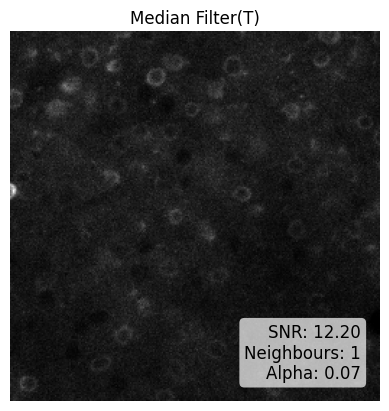

In [ ]:
def objective(trial):
    # Define the hyperparameters to optimize
    median_neighbours = trial.suggest_int('N', 1, 3)
    median_alpha = trial.suggest_uniform('A', 0.01, 1.0)

    # Apply the filters with the suggested hyperparameters
    median_filtered = apply_filters(noisy_data,
                                    median_neighbours=median_neighbours,
                                    median_alpha=median_alpha)[1]  # Assuming index 1 corresponds to median_filtered

    filtered_image = median_filtered[4]
    gt_image = gt_data[4]


    denoised_snr = calculate_snr(gt_image, filtered_image)

    # Return the metric to optimize (e.g., maximize SNR of denoised image)
    # Optuna minimizes the objective function, so we return -denoised_snr if maximizing
    return -denoised_snr

# Create an Optuna study object
study_okada = optuna.create_study(direction='minimize')

# Optimize the objective function
study_okada.optimize(objective, n_trials=50)  # You can adjust the number of trials

# Print the best parameters and corresponding SNR
print('Best parameters:', study_okada.best_params)
print('Best SNR:', -study_okada.best_value)

# Plot results (if you have any plotting function for your results)
# plot_image_with_snr(filtered_image, noisy_snr, -study.best_value, path, title)


median_filtered = apply_filters(noisy_data,
                                median_neighbours=study_okada.best_params['N'],
                                median_alpha=study_okada.best_params['A'])[1]  # Assuming index 1 corresponds to median_filtered
# Print SNRs
denoised_snr_okada = calculate_snr(gt_data[3], median_filtered[3])
print(f'SNR of denoised image: {denoised_snr_okada}')
path = '/content/drive/MyDrive/MastersThesis/Analysis/data/NAOMi/Median_filtered_image.png'
title = 'Median Filter(T)'
weights_okada= (study_okada.best_params['N'], study_okada.best_params['A'])
plot_image_with_snr_okada(median_filtered[3], denoised_snr_okada, weights_okada, path, title)


# Bilateral Filter

In [ ]:
def plot_image_with_snr_bilateral(image, denoised_snr, weights, filename='filtered_image.png', title='Filtered Image'):
    """
    Plot an image with SNR annotations and save it as a PNG file.

    Parameters:
    - image: The image to plot.
    - denoised_snr: The SNR of the filtered image compared to the ground truth.
    - weights: The list of weights used in the filtering process.
    - filename: The name of the file to save the plot as.
    - title: The title of the plot.
    """
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

    neighbours=weights[0]
    alpha=weights[1]  # Assuming index 1 corresponds to median_filtered
    # Format weights into a string
    diameter = weights[0]
    sigma_colour = weights[1]
    sigma_space = weights[2]
    weights_str = f'Neighbours: {diameter}\nSigma Colour: {sigma_colour:.2f}\nSigma Space: {sigma_space:.2f}'


    # Annotation text
    text = f'SNR: {denoised_snr:.2f}\n{weights_str}'

    # Create a patch to place the text
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.7)
    ax.text(0.95, 0.05, text, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', horizontalalignment='right', bbox=bbox_props)

    # Save the plot as a PNG file
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close(fig)

[I 2024-09-02 04:17:29,155] A new study created in memory with name: no-name-99f7ecbb-444a-4d3a-9c6d-9f2bbf01d733
[I 2024-09-02 04:17:29,189] Trial 0 finished with value: 11.16367244720459 and parameters: {'diameter': 7, 'sigma_colour': 42.61090605156844, 'sigma_space': 10.07038650566382}. Best is trial 0 with value: 11.16367244720459.
[I 2024-09-02 04:17:29,196] Trial 1 finished with value: 9.653853416442871 and parameters: {'diameter': 3, 'sigma_colour': 30.546690396070744, 'sigma_space': 7.497530903886539}. Best is trial 0 with value: 11.16367244720459.
[I 2024-09-02 04:17:29,223] Trial 2 finished with value: -3.3689236640930176 and parameters: {'diameter': 10, 'sigma_colour': 11.735403419755592, 'sigma_space': 19.456848237507}. Best is trial 0 with value: 11.16367244720459.
[I 2024-09-02 04:17:29,238] Trial 3 finished with value: 10.384315490722656 and parameters: {'diameter': 7, 'sigma_colour': 37.503999972835956, 'sigma_space': 14.327761195908794}. Best is trial 0 with value: 11.

Best parameters: {'diameter': 3, 'sigma_colour': 49.98544706289742, 'sigma_space': 2.361280270232914}
Best SNR: 12.295327186584473
SNR of denoised image: 13.784845352172852


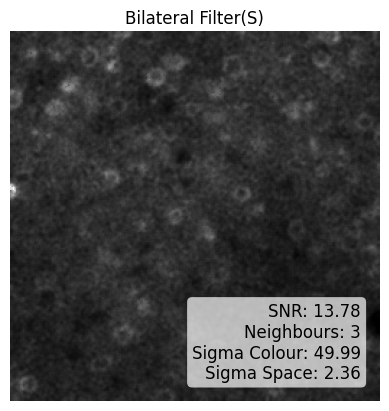

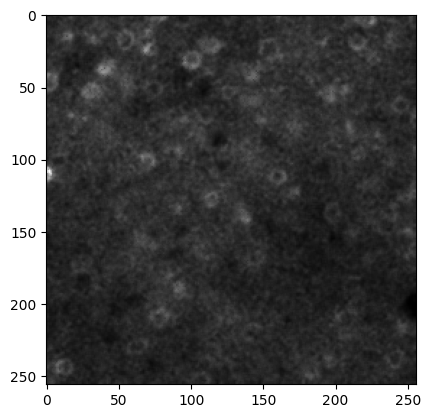

In [ ]:
def bilateral_filter(image, diameter, sigma_colour, sigma_space):
    """
    Applies bilateral filtering to a grayscale image.

    :param image: Input image (2D tensor, shape: [H, W]).
    :param diameter: Diameter of the filter.
    :param sigma_color: Filter sigma in the color space.
    :param sigma_space: Filter sigma in the coordinate space.
    :return: Filtered image (2D tensor, shape: [H, W]).
    """
    # Ensure the image is a 4D tensor (B, C, H, W) for PyTorch
    if len(image.shape) == 2:
        image = image.unsqueeze(0).unsqueeze(0)

    # Create a meshgrid for the spatial component
    kernel_size = diameter
    half_size = kernel_size // 2
    x = torch.arange(-half_size, half_size + 1, device=image.device).float()
    y = torch.arange(-half_size, half_size + 1, device=image.device).float()
    X, Y = torch.meshgrid(x, y, indexing='ij')

    spatial_weight = torch.exp(-(X**2 + Y**2) / (2 * sigma_space**2))

    # Apply padding to the image to handle borders
    padded_image = F.pad(image, (half_size, half_size, half_size, half_size), mode='reflect')

    # Prepare an empty tensor to accumulate the filtered result
    filtered_image = torch.zeros_like(image)

    # Iterate over the filter window
    for i in range(kernel_size):
        for j in range(kernel_size):
            # Offset the padded image
            shifted_image = padded_image[:, :, i:i + image.shape[2], j:j + image.shape[3]]

            # Compute the color weight
            intensity_diff = shifted_image - image
            color_weight = torch.exp(-(intensity_diff ** 2) / (2 * sigma_colour ** 2))

            # Compute the combined weight
            combined_weight = spatial_weight[i, j] * color_weight

            # Accumulate the weighted intensity
            filtered_image += combined_weight * shifted_image

    # Normalize the filtered image by the sum of weights
    normalization_factor = torch.sum(spatial_weight)
    filtered_image /= normalization_factor

    return filtered_image.squeeze()


def objective(trial):
    diameter = trial.suggest_int('diameter', 1, 10)
    sigma_colour = trial.suggest_float('sigma_colour', 0.1, 50.0)
    sigma_space = trial.suggest_float('sigma_space', 0.1, 20.0)

    filtered_image = bilateral_filter(noisy_data[4], diameter, sigma_colour, sigma_space)
    snr = calculate_snr(filtered_image, gt_data[0])

    return snr

# Create a study object and optimize
study_bilateral = optuna.create_study(direction='maximize')
study_bilateral.optimize(objective, n_trials=100)

print(f'Best parameters: {study_bilateral.best_params}')
print(f'Best SNR: {study_bilateral.best_value}')


best_diameter = study_bilateral.best_params['diameter']
best_sigma_colour = study_bilateral.best_params['sigma_colour']
best_sigma_space = study_bilateral.best_params['sigma_space']

filtered_image_bilateral = bilateral_filter(noisy_data[4], best_diameter, best_sigma_colour, best_sigma_space)
denoised_snr_bilateral = calculate_snr(gt_data[4], filtered_image_bilateral)

print(f'SNR of denoised image: {denoised_snr_bilateral}')
path = '/content/drive/MyDrive/MastersThesis/Analysis/data/NAOMi/Bilateral_filter_image.png'
title = 'Bilateral Filter(S)'
weights_bilateral= (best_diameter, best_sigma_colour, best_sigma_space)
plot_image_with_snr_bilateral(filtered_image_bilateral, denoised_snr_bilateral,weights_bilateral,path, title)

plt.imshow(filtered_image_bilateral, cmap='gray')
plt.show()


# Wiener Filter

In [ ]:
def plot_image_with_snr_wiener(image, denoised_snr, weights, filename='filtered_image.png', title='Filtered Image'):
    """
    Plot an image with SNR annotations and save it as a PNG file.

    Parameters:
    - image: The image to plot.
    - denoised_snr: The SNR of the filtered image compared to the ground truth.
    - weights: The list of weights used in the filtering process.
    - filename: The name of the file to save the plot as.
    - title: The title of the plot.
    """
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

    kernel_size = weights[0]
    noise_variance = weights[1]
    # Format weights into a string
    weights_str = f'Kernel Size: {kernel_size}\nNoise Variance: {noise_variance:.2f}'


    # Annotation text
    text = f'SNR: {denoised_snr:.2f}\n{weights_str}'

    # Create a patch to place the text
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.7)
    ax.text(0.95, 0.05, text, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', horizontalalignment='right', bbox=bbox_props)

    # Save the plot as a PNG file
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close(fig)

[I 2024-09-02 04:17:32,176] A new study created in memory with name: no-name-483b312a-19a7-4e61-90b5-8bf8f6a7fbe1
[I 2024-09-02 04:17:32,186] Trial 0 finished with value: -9.199007034301758 and parameters: {'kernel_size': 6, 'noise_variance': 3.9267705799368033}. Best is trial 0 with value: -9.199007034301758.
[I 2024-09-02 04:17:32,191] Trial 1 finished with value: -8.978615760803223 and parameters: {'kernel_size': 7, 'noise_variance': 0.06866169832395606}. Best is trial 0 with value: -9.199007034301758.
[I 2024-09-02 04:17:32,196] Trial 2 finished with value: -8.975497245788574 and parameters: {'kernel_size': 8, 'noise_variance': 0.01489015772200925}. Best is trial 0 with value: -9.199007034301758.
[I 2024-09-02 04:17:32,202] Trial 3 finished with value: -10.572089195251465 and parameters: {'kernel_size': 13, 'noise_variance': 36.25421946006029}. Best is trial 3 with value: -10.572089195251465.
[I 2024-09-02 04:17:32,207] Trial 4 finished with value: -9.171106338500977 and parameters

Best parameters:  {'kernel_size': 7, 'noise_variance': 99.75710471955617}
Best SNR:  12.505939483642578


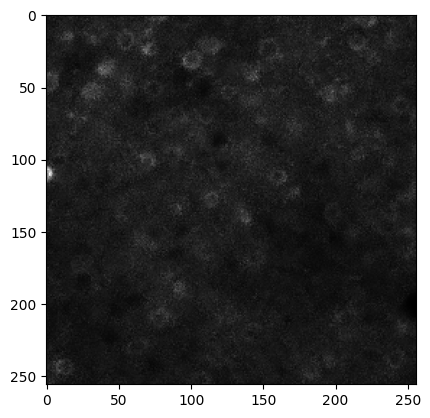

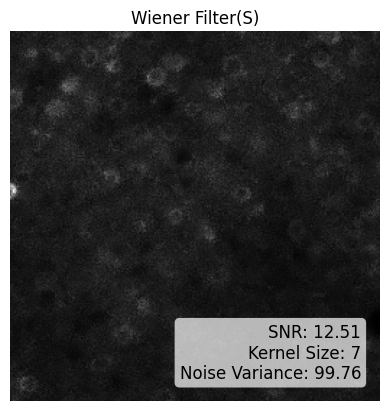

In [ ]:
def wiener_filter(noisy_image, kernel_size, noise_variance):
    """
    Apply Wiener filtering to a grayscale image.

    Parameters:
    - noisy_image: The noisy image to filter (PyTorch tensor).
    - kernel_size: The size of the local neighborhood (kernel) for filtering.
    - noise_variance: The variance of the noise in the image.

    Returns:
    - filtered_image: The Wiener-filtered image (PyTorch tensor).
    """
    # Convert noisy_image to numpy array
    noisy_image = noisy_image.cpu().numpy().squeeze()

    # Convert to float for precision
    noisy_image = noisy_image.astype(float)

    # Local mean and variance
    local_mean = uniform_filter(noisy_image, size=kernel_size)
    local_var = uniform_filter(noisy_image ** 2, size=kernel_size) - local_mean ** 2

    # Wiener filter computation
    filter_strength = local_var / (local_var + noise_variance)
    filtered_image = local_mean + filter_strength * (noisy_image - local_mean)

    # Clip values to be in valid range (0-255)
    filtered_image = np.clip(filtered_image, 0, 255)

    # Convert back to PyTorch tensor
    filtered_image = torch.from_numpy(filtered_image).float().unsqueeze(0)

    return filtered_image.squeeze(0)


def objective(trial):
    # Suggest values for kernel_size and noise_variance
    kernel_size = trial.suggest_int('kernel_size', 3, 15)  # Kernel size can be 3x3 to 15x15
    noise_variance = trial.suggest_float('noise_variance', 1e-2, 1e2, log=True)  # Log scale for variance

    # Apply Wiener filter with suggested parameters
    filtered_image = wiener_filter(noisy_data[4], kernel_size, noise_variance)

    # Calculate SNR
    snr = calculate_snr(gt_data[4], filtered_image)

    # We want to maximize SNR, so we return the negative SNR to minimize it
    return -snr

# Create a study and optimize it
study_wiener = optuna.create_study(direction='minimize')
study_wiener.optimize(objective, n_trials=100)

# Print the best parameters and SNR
print("Best parameters: ", study_wiener.best_params)
print("Best SNR: ", -study_wiener.best_value)

# Apply the best Wiener filter
best_kernel_size = study_wiener.best_params['kernel_size']
best_noise_variance = study_wiener.best_params['noise_variance']
weights_wiener = (best_kernel_size, best_noise_variance)
filtered_image_wiener = wiener_filter(noisy_data[4], best_kernel_size, best_noise_variance)

# Show the best filtered image

plt.imshow(filtered_image_wiener , cmap='gray')
plt.show()


denoised_snr_wiener = calculate_snr(gt_data[4], filtered_image_wiener)
path = '/content/drive/MyDrive/MastersThesis/Analysis/data/NAOMi/Wiener_filtered_image.png'
title = 'Wiener Filter(S)'
plot_image_with_snr_wiener(filtered_image_wiener, denoised_snr_wiener, weights_wiener, path, title)



# Order Statistic Filter

In [ ]:
def plot_image_with_snr_OSF(image, denoised_snr, weights, filename='filtered_image.png', title='Filtered Image'):
    """
    Plot an image with SNR annotations and save it as a PNG file.

    Parameters:
    - image: The image to plot.
    - denoised_snr: The SNR of the filtered image compared to the ground truth.
    - weights: The list of weights used in the filtering process.
    - filename: The name of the file to save the plot as.
    - title: The title of the plot.
    """
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

    # Format weights into a string
    frame_str = '\n'.join(f'Frame {i+1}: {weight:.2f}' for i, weight in enumerate(weights))

    # Annotation text
    text = f'SNR: {denoised_snr:.2f}\n{frame_str}'

    # Create a patch to place the text
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.7)
    ax.text(0.95, 0.05, text, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', horizontalalignment='right', bbox=bbox_props)

    # Save the plot as a PNG file
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close(fig)

[I 2024-09-02 04:17:34,342] A new study created in memory with name: no-name-d6d449ee-f8a3-4b34-bc42-934ee9c9c1c0
[I 2024-09-02 04:17:34,367] Trial 0 finished with value: -14.585280585394617 and parameters: {'weight_0': 0.38486487794484026, 'weight_1': 0.8151149482703276, 'weight_2': 0.5341896041885207, 'weight_3': 0.5005518217110991, 'weight_4': 0.6211839278032606}. Best is trial 0 with value: -14.585280585394617.
[I 2024-09-02 04:17:34,379] Trial 1 finished with value: -15.135207208930224 and parameters: {'weight_0': 0.28966700261405287, 'weight_1': 0.878709033846457, 'weight_2': 0.5198504257891494, 'weight_3': 0.27428899660688555, 'weight_4': 0.8629080920031285}. Best is trial 1 with value: -15.135207208930224.
[I 2024-09-02 04:17:34,389] Trial 2 finished with value: -13.824837952405144 and parameters: {'weight_0': 0.4902927046358295, 'weight_1': 0.31301893508661705, 'weight_2': 0.9900281098905768, 'weight_3': 0.37846433682944935, 'weight_4': 0.373079378979124}. Best is trial 1 with

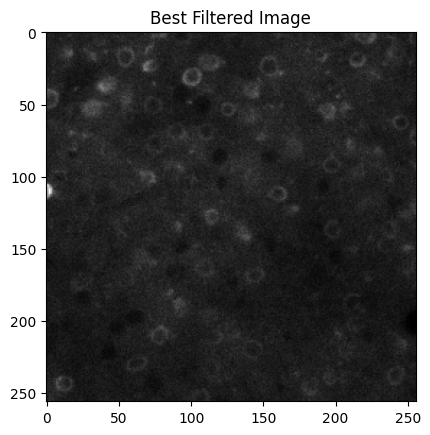

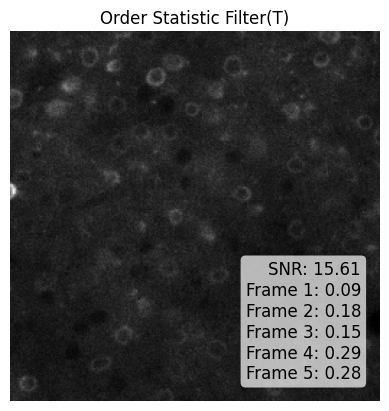

In [ ]:
def temporal_weighted_order_statistic_filter(image_stack, weights):
    """
    Apply a temporal weighted order statistic filter to a stack of images.

    Parameters:
    - image_stack: The input image stack (torch tensor) of shape (num_frames, height, width).
    - weights: A list of weights corresponding to the sorted pixel values over time.

    Returns:
    - filtered_image: The filtered image (torch tensor) of shape (height, width).
    """
    num_frames, height, width = image_stack.shape

    # Sort the pixel values across the temporal dimension
    sorted_pixels = torch.sort(image_stack, dim=0)[0]

    # Apply the weights to the sorted pixel values
    weights_tensor = torch.tensor(weights).view(num_frames, 1, 1)
    weighted_sum = torch.sum(sorted_pixels * weights_tensor, dim=0)

    return weighted_sum


def objective(trial):
    num_frames = noisy_data.shape[0]

    # Suggest weights for each frame
    weights = [trial.suggest_float(f'weight_{i}', 0, 1) for i in range(num_frames)]

    # Normalize weights so they sum to 1
    weights = np.array(weights)
    weights /= weights.sum()




    # Apply the temporal weighted order statistic filter with the suggested weights
    filtered_image = temporal_weighted_order_statistic_filter(noisy_data, weights)

    # Calculate SNR
    snr = calculate_snr(gt_data[3], filtered_image)

    # We want to maximize SNR, so we return the negative SNR to minimize it
    return -snr


# Create a study and optimize it
study_OSF= optuna.create_study(direction='minimize')
study_OSF.optimize(objective, n_trials=100)

# Extract the best parameters and SNR
weights_OSF = [study_OSF.best_params[f'weight_{i}'] for i in range(noisy_data.shape[0])]
filtered_image_OSF = temporal_weighted_order_statistic_filter(noisy_data, weights_OSF)

# normalilze best weights
weights_OSF = np.array(weights_OSF)
weights_OSF /= weights_OSF.sum()

# Display the best filtered image
plt.imshow(filtered_image_OSF, cmap='gray')
plt.title("Best Filtered Image")
plt.show()

path = '/content/drive/MyDrive/MastersThesis/Analysis/data/NAOMi/Order_Statistic_filtered_image.png'
title = 'Order Statistic Filter(T)'
plot_image_with_snr_OSF(filtered_image_OSF, -study_OSF.best_value, weights_OSF,path, title)

# Kalman Filter

In [ ]:
def plot_image_with_snr_kalman(image, denoised_snr, weights, filename='filtered_image.png', title='Filtered Image'):
    """
    Plot an image with SNR annotations and save it as a PNG file.

    Parameters:
    - image: The image to plot.
    - denoised_snr: The SNR of the filtered image compared to the ground truth.
    - weights: The list of weights used in the filtering process.
    - filename: The name of the file to save the plot as.
    - title: The title of the plot.
    """
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

    Q  = weights[0]
    R = weights[1]
    # Format weights into a string
    weights_str = f'P Covariance: {Q:.2f}\nM Covariance: {R:.2f}'


    # Annotation text
    text = f'SNR: {denoised_snr:.2f}\n{weights_str}'

    # Create a patch to place the text
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.7)
    ax.text(0.95, 0.05, text, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', horizontalalignment='right', bbox=bbox_props)

    # Save the plot as a PNG file
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close(fig)

[I 2024-09-02 04:17:40,405] A new study created in memory with name: no-name-42da536b-b03b-4943-b36e-3a3709db5067
[I 2024-09-02 04:17:40,413] Trial 0 finished with value: 11.939332962036133 and parameters: {'Q': 0.5018429270462734, 'R': 0.9789354412590714}. Best is trial 0 with value: 11.939332962036133.
[I 2024-09-02 04:17:40,418] Trial 1 finished with value: 12.189807891845703 and parameters: {'Q': 0.13502762455231335, 'R': 0.5734601478853286}. Best is trial 1 with value: 12.189807891845703.
[I 2024-09-02 04:17:40,423] Trial 2 finished with value: 12.258455276489258 and parameters: {'Q': 0.14249200886412425, 'R': 0.5396788424531709}. Best is trial 2 with value: 12.258455276489258.
[I 2024-09-02 04:17:40,428] Trial 3 finished with value: 12.382584571838379 and parameters: {'Q': 0.15562248810371063, 'R': 0.38620992888332095}. Best is trial 3 with value: 12.382584571838379.
[I 2024-09-02 04:17:40,433] Trial 4 finished with value: 11.679889678955078 and parameters: {'Q': 0.34261949518491

Best parameters: {'Q': 0.01056193258091806, 'R': 0.054136011454328524}
Best score (MSE): 13.244362831115723


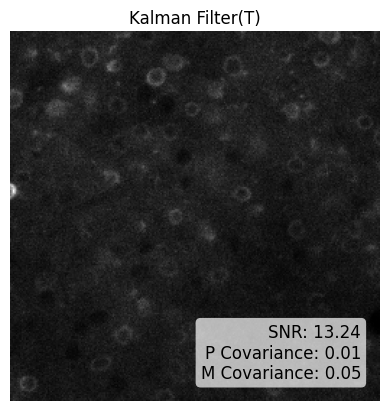

In [ ]:

from sklearn.metrics import mean_squared_error

def kalman_filter(noisy_data, Q, R):
    """
    Apply Kalman filter to denoise a stack of 2D image frames.
    """
    z, x, y = noisy_data.shape
    x_hat = torch.zeros(z, x, y, device=noisy_data.device)
    P = torch.ones(z, x, y, device=noisy_data.device) * 1.0

    for t in range(1, z):
        x_hat_minus = x_hat[t-1]
        P_minus = P[t-1] + Q
        K = P_minus / (P_minus + R)
        x_hat[t] = x_hat_minus + K * (noisy_data[t] - x_hat_minus)
        P[t] = (1 - K) * P_minus

    return x_hat

def objective(trial):
    """
    Objective function for Optuna to optimize the Kalman filter parameters.
    """
    # Define the hyperparameters to optimize
    Q = trial.suggest_float('Q', 0.01, 1.0)
    R = trial.suggest_float('R', 0.01, 1.0)

    # Apply Kalman filter
    denoised_data = kalman_filter(noisy_data, Q, R)

    # Calculate MSE between denoised and ground truth data
    mse = calculate_snr(gt_data[4], denoised_data[4])
    return mse

# Create and run the Optuna study
study_kalman = optuna.create_study(direction='maximize')
study_kalman.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Print the best parameters and their corresponding score
print('Best parameters:', study_kalman.best_params)
print('Best score (MSE):', study_kalman.best_value)


path = '/content/drive/MyDrive/MastersThesis/Analysis/data/NAOMi/Kalman_Filtered.png'
title = 'Kalman Filter(T)'
denoised_data = kalman_filter(noisy_data, study_kalman.best_params['Q'], study_kalman.best_params['R'])
filtered_image = denoised_data[4]
denoised_snr = calculate_snr(gt_data[4], filtered_image)
weights_kalman = (study_kalman.best_params['Q'], study_kalman.best_params['R'])
plot_image_with_snr_kalman(filtered_image, denoised_snr, weights_kalman, path, title)


# Noise Examples

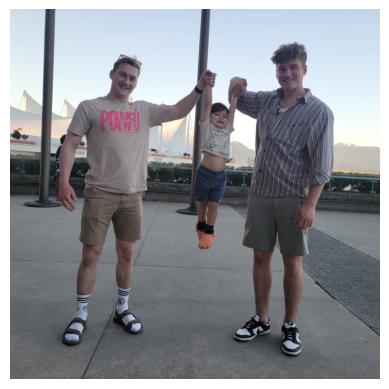

In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image
import torch

# Path to your image file
image_path = '/content/drive/MyDrive/MastersThesis/Analysis/data/Internal Statistics/ZachKyeTravis.png'
image = Image.open(image_path)

# Convert the image to a PyTorch tensor

img = np.array(image)
# Display the image using matplotlib
plt.imshow(img / 255.0)  # Normalizing the image for display
plt.axis('off')  # Optional: Turn off axis
plt.show()


In [ ]:
# prompt: Take img and make one with guassian noise added, sallt and pepper, quantized , and speckledaand

import numpy as np
import random

def add_gaussian_noise(img, mean=0, std=10):
  """Adds Gaussian noise to an image."""
  noise = np.random.normal(mean, std, img.shape)
  noisy_img = img + noise
  noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)  # Ensure valid pixel values
  return noisy_img

def add_salt_and_pepper_noise(img, salt_vs_pepper=0.5, amount=0.004):
  """Adds salt and pepper noise to an image."""
  noisy_img = img.copy()
  num_salt = np.ceil(amount * img.size * salt_vs_pepper)
  coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape]
  noisy_img[tuple(coords)] = 255  # Salt

  num_pepper = np.ceil(amount * img.size * (1. - salt_vs_pepper))
  coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape]
  noisy_img[tuple(coords)] = 0  # Pepper
  return noisy_img

def quantize_image(img, levels=8):
  """Quantizes an image to a reduced number of intensity levels."""
  bins = np.linspace(0, 255, levels + 1)
  quantized_img = np.digitize(img, bins) - 1
  quantized_img = (quantized_img / (levels - 1) * 255).astype(np.uint8)
  return quantized_img

def add_speckle_noise(img, mean=0, std=0.05):
  """Adds speckle noise to an image."""
  noise = np.random.normal(mean, std, img.shape)
  noisy_img = img + img * noise
  noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
  return noisy_img


def add_poisson_noise2(data, noise_scale=150):
    # Ensure data is in float format and normalized to [0, 1]
    if np.max(data) > 1.0:
        data = data / 255.0

    gt_data = torch.from_numpy(data).float()

    # Apply Poisson noise
    noisy_data = torch.poisson(gt_data * noise_scale) / noise_scale

    # Clip values to [0, 1] range
    noisy_data = torch.clamp(noisy_data, 0, 1)

    # Convert tensor to NumPy array
    noisy_data = noisy_data.numpy()

    return noisy_data


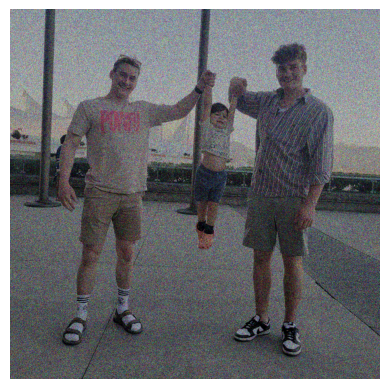

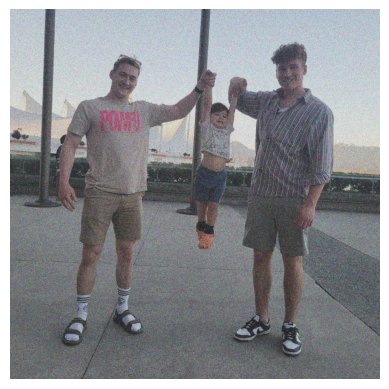

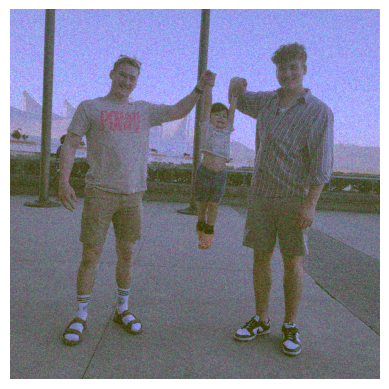

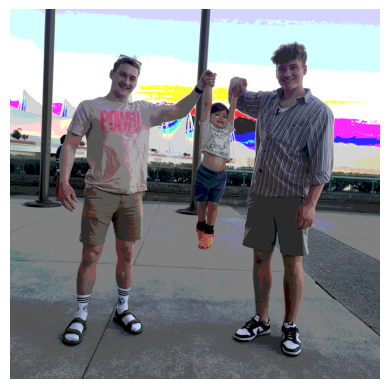

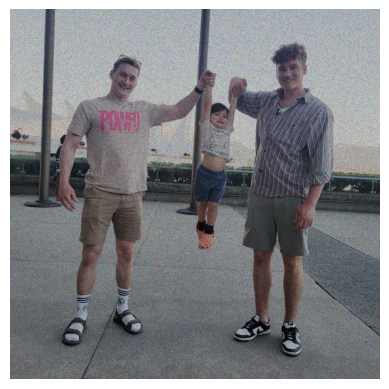

In [ ]:
mean = 0
std = 100
gaussian_noisy_img = add_gaussian_noise(img, mean, std)

amount = 0.5
salt_vs_pepper = 0.5
salt_pepper_noisy_img = add_salt_and_pepper_noise(img, salt_vs_pepper, amount)


levels = 7
quantized_img = quantize_image(img, levels)



mean = 0
std =  0.8
speckled_img = add_speckle_noise(img, mean , std)

import matplotlib.pyplot as plt

# Add noise to the image
mean = 0
std = 100
gaussian_noisy_img = add_gaussian_noise(img, mean, std)

amount = 0.5
salt_vs_pepper = 0.5
salt_pepper_noisy_img = add_salt_and_pepper_noise(img, salt_vs_pepper, amount)

levels = 7
quantized_img = quantize_image(img, levels)

mean = 0
std = 0.8
speckled_img = add_speckle_noise(img, mean, std)


noise_scale = 1
poisson_img = add_poisson_noise2(img, noise_scale)




# Create a directory for saving plots if it doesn't exist
save_dir = '/content/drive/MyDrive/MastersThesis/Analysis/data/Internal Statistics'

plt.figure()
plt.imshow(poisson_img, cmap='gray')
plt.axis('off')
plt.savefig(f'{save_dir}/poisson_img.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

# Plot and save Gaussian noisy image
plt.figure()
plt.imshow(gaussian_noisy_img, cmap='gray')
plt.axis('off')
plt.savefig(f'{save_dir}/gaussian_noisy_img.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

# Plot and save Salt-and-Pepper noisy image
plt.figure()
plt.imshow(salt_pepper_noisy_img, cmap='gray')
plt.axis('off')
plt.savefig(f'{save_dir}/salt_pepper_noisy_img.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

# Plot and save Quantized image
plt.figure()
plt.imshow(quantized_img, cmap='gray')
plt.axis('off')
plt.savefig(f'{save_dir}/quantized_img.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

# Plot and save Speckle noisy image
plt.figure()
plt.imshow(speckled_img, cmap='gray')
plt.axis('off')
plt.savefig(f'{save_dir}/speckled_img.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()


# Poisson Shot-Noise


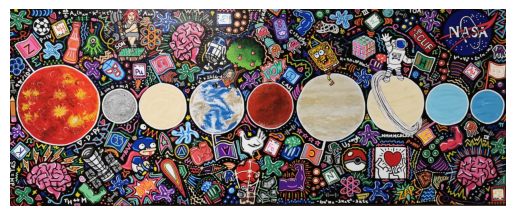

In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image
import torch

# Path to your image file
image_path = '/content/drive/MyDrive/MastersThesis/Analysis/data/Internal Statistics/AlyssaPainting.jpg'
image = Image.open(image_path)

# Convert the image to a PyTorch tensor

img = np.array(image)
# Display the image using matplotlib
plt.imshow(img / 255.0)  # Normalizing the image for display
plt.axis('off')  # Optional: Turn off axis
plt.show()


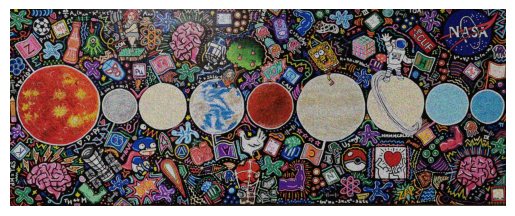

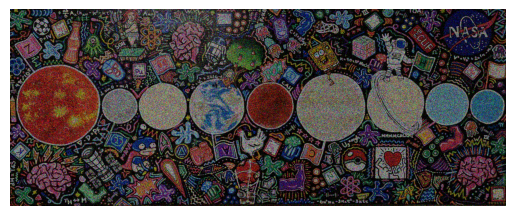

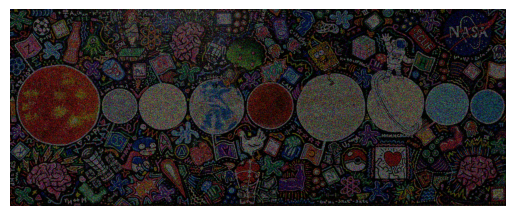

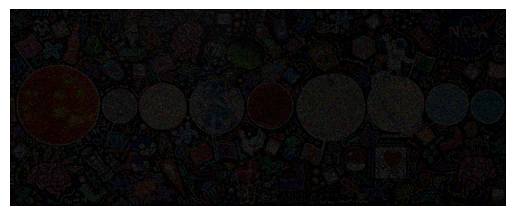

In [ ]:
noise_scale = 3
poisson_img1 = add_poisson_noise2(img, noise_scale)

noise_scale = 0.75
poisson_img2 = add_poisson_noise2(img, noise_scale)


noise_scale = 0.4
poisson_img3 = add_poisson_noise2(img, noise_scale)


noise_scale = 0.1
poisson_img4 = add_poisson_noise2(img, noise_scale)


# plt all lthe iammges in a tight lalyout


# Create a directory for saving plots if it doesn't exist
save_dir = '/content/drive/MyDrive/MastersThesis/Analysis/data/Internal Statistics'

plt.figure()
plt.imshow(poisson_img1, cmap='gray')
plt.axis('off')
plt.savefig(f'{save_dir}/poisson_img1.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()
plt.figure()
plt.imshow(poisson_img2, cmap='gray')
plt.axis('off')
plt.savefig(f'{save_dir}/poisson_img2.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()
plt.figure()
plt.imshow(poisson_img3, cmap='gray')
plt.axis('off')
plt.savefig(f'{save_dir}/poisson_img3.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()
plt.figure()
plt.imshow(poisson_img4, cmap='gray')
plt.axis('off')
plt.savefig(f'{save_dir}/poisson_img4.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()



# Data Augmentations


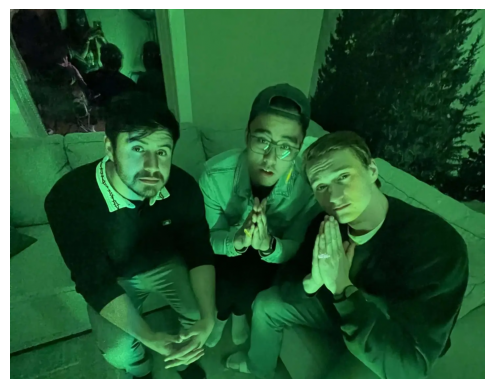

In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image
import torch

# Path to your image file
image_path = '/content/drive/MyDrive/MastersThesis/Analysis/data/Internal Statistics/QuinnPhamZach.png'
image = Image.open(image_path)

# Convert the image to a PyTorch tensor

img = np.array(image)
# Display the image using matplotlib
plt.imshow(img / 255.0)  # Normalizing the image for display
plt.axis('off')  # Optional: Turn off axis
plt.show()


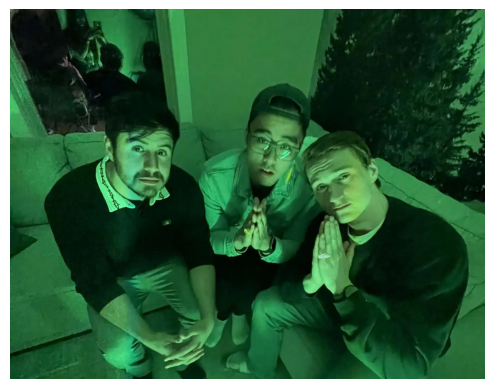

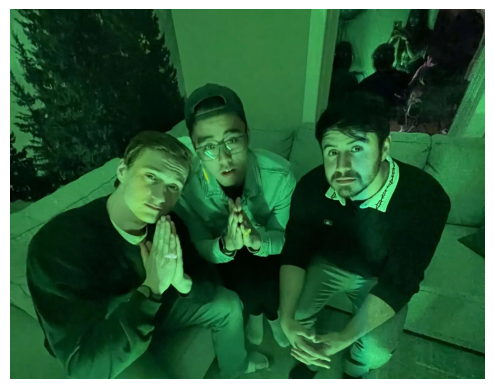

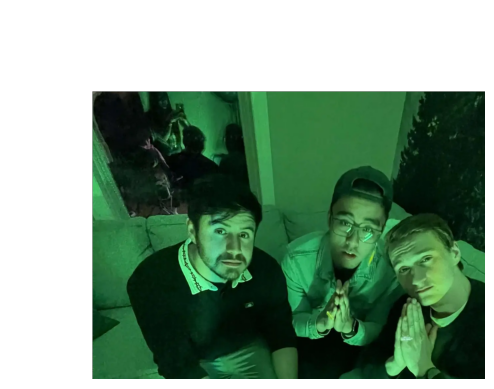

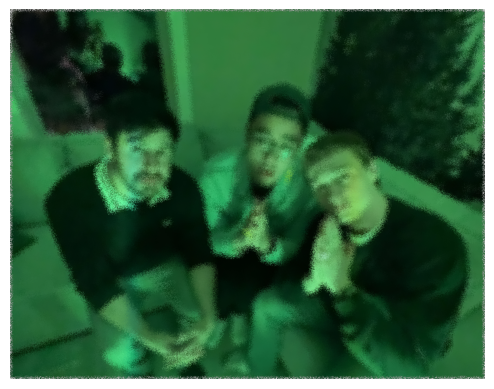

In [ ]:
# prompt: Peform A flipp, shift, elastic defformation, and a local wwindow on this image. make them all separate images

import matplotlib.pyplot as plt
import numpy as np
import cv2

# Flip
flipped_img = cv2.flip(img, 1)  # 1 for horizontal flip, 0 for vertical

# Shift
rows, cols, _ = img.shape
shift_x = 250  # Shift to the right
shift_y = 250  # Shift down
M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
shifted_img = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))


# Elastic Deformation (using OpenCV's remap)
# This is a simplified example, you might need to adjust parameters based on your image
h, w, _ = img.shape
grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
displacement_x = np.random.rand(h, w) * 20 - 10  # Adjust magnitude as needed
displacement_y = np.random.rand(h, w) * 20 - 10  # Adjust magnitude as needed
map_x = (grid_x + displacement_x).astype(np.float32)
map_y = (grid_y + displacement_y).astype(np.float32)
elastic_img = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR)

# Local Window
window_size = 150  # Adjust as needed
center_x = img.shape[1] // 2
center_y = img.shape[0] // 2
x1 = center_x - window_size // 2
y1 = center_y - window_size // 2
x2 = center_x + window_size // 2
y2 = center_y + window_size // 2
local_window_img = img[y1:y2, x1:x2]


save_dir = '/content/drive/MyDrive/MastersThesis/Analysis/data/Internal Statistics'
# Display or save the images

plt.figure()
plt.imshow(img)
plt.axis('off')
plt.savefig(f'{save_dir}/QPZ_GT.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

plt.figure()
plt.imshow(flipped_img)
plt.axis('off')
plt.savefig(f'{save_dir}/QPZ_Flipped.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

plt.figure()
plt.imshow(shifted_img)
plt.axis('off')
plt.savefig(f'{save_dir}/QPZ_Shifted.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

plt.figure()
plt.imshow(elastic_img)
plt.axis('off')
plt.savefig(f'{save_dir}/QPZ_Elastic.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()
